# Introduction
Determin Porygon DT of Sampled Users to Each Restaurant


# Data collection
We get the data from big query.

In [108]:
# load packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
%matplotlib inline
#from google.colab import drive # to allow colab save file in my drive
#drive.mount('drive')
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is not loaded.


## 1. Create temp tables

First you need to define in which country, which city and which vehicle_profile_tbd you want it to run. 

Second, you run the query to create table

Third, you request the table data as a data frame.

In [57]:
# define some variables
project_id = "fulfillment-dwh-production"
country_code_tbd = "tw" 
city_id_tbd = "3"
vehicle_profile_tbd = "default"
geohash_digit = "6"

# define project id
client = bigquery.Client(project = project_id)

print("This script will return price points result in a table for {a} as vehicle profile with {b}-digit geohash in City {c} of Country {d}".format(a=vehicle_profile_tbd, b=geohash_digit, c=city_id_tbd, d=country_code_tbd))

This script will return price points result in a table for default as vehicle profile with 6-digit geohash in City 3 of Country tw


In [0]:
# Create temp tables 
query = """
-- zone_temp to get basic zone table information
drop table if exists `temp.zone_temp_""" + country_code_tbd + """`;
CREATE TABLE `temp.zone_temp_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		country_code,
		c.id as city_id,
		c.name as city_name,
		z.id as zone_id,
		z.name as zone_name,
		st_astext(z.shape) as zone_shape,
		z.zone_shape_updated_at as zone_update,
	from `fulfillment-dwh-production.cl.countries`
	left join unnest(cities) c
	left join unnest(c.zones) z
	where country_code = \"""" + country_code_tbd + """\" 
  and c.id = """ + city_id_tbd + """
  group by 1,2,3,4,5,6,7);

-- zone table to ge the most uptodate zone shape
drop table if exists `temp.zone_""" + country_code_tbd + """`;
CREATE TABLE `temp.zone_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select a.*
	from temp.zone_temp_""" + country_code_tbd + """ a
	join
		(select
			country_code,
			city_id,
			zone_id,
			zone_name,
			zone_shape,
			max(zone_update) as zone_update
		from temp.zone_temp_""" + country_code_tbd + """
		group by 1,2,3,4,5) b
	on a.country_code = b.country_code and a.city_id = b.city_id and a.zone_id = b.zone_id and a.zone_update = b.zone_update);

-- res_location table to get restaurant location info
drop table if exists `temp.res_location_""" + country_code_tbd + """`;
CREATE TABLE `temp.res_location_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		country_code,
		city_id,
		vendor_code,
		st_x(location) as res_long,
		st_y(location) as res_lat,
	from `fulfillment-dwh-production.cl.vendors`
	left join unnest(delivery_areas) d
	where country_code = \"""" + country_code_tbd + """\" 
	and city_id = """ + city_id_tbd + """
	group by 1,2,3,4,5);

-- res_zone to map restaurant with zone_id by looking at restaurant location and up-to-date zone shape
drop table if exists `temp.res_zone_""" + country_code_tbd + """`;
CREATE TABLE `temp.res_zone_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		z.country_code,
		z.city_id,
		vendor_code,
		z.zone_id  as res_zone_id
	from temp.zone_""" + country_code_tbd + """ z
	inner join temp.res_location_""" + country_code_tbd + """ r
	on z.country_code = r.country_code
	and z.city_id = r.city_id
	and st_within(st_geogpoint(r.res_long,r.res_lat), st_geogfromtext(z.zone_shape)));

-- each restaurant should has its zone_id, restaurant could have more than one zone_id
drop table if exists `temp.res_zoneid_""" + country_code_tbd + """`;
CREATE TABLE `temp.res_zoneid_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		country_code,
		city_id,
		vendor_code,
		res_zone_id
	from temp.res_zone_""" + country_code_tbd + """
	where true
	and res_zone_id is not null
	group by 1,2,3,4);

--add porygon vehicle_profile by restaurant .. asdas

-- porygon_temp table to have up to date porygon area
drop table if exists `temp.porygon_temp_""" + country_code_tbd + """`;
CREATE TABLE `temp.porygon_temp_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		a.restaurant_id,
		a.time,
		a.country_code,
		a.shape_wkt
	from `fulfillment-dwh-production.dl.porygon_drive_time_polygons` a
	inner join
		(select
			restaurant_id,
			time,
			country_code,
			shape_wkt,
			vehicle_profile,
			max(updated_at) as updated_at
		from `fulfillment-dwh-production.dl.porygon_drive_time_polygons`
		where vehicle_profile = \"""" + vehicle_profile_tbd + """\" 
    and country_code = \"""" + country_code_tbd + """\" 
		group by 1,2,3,4,5) b
	on a.restaurant_id = b.restaurant_id and a.country_code = b.country_code and a.updated_at = b.updated_at
	group by 1,2,3,4);

-- make the timeframe dynamic (last x days?)

-- porygon table to have zone_id for each restaurant and up-to-date shape for different driving times with car-reduced
drop table if exists `temp.porygon_""" + country_code_tbd + """`;
CREATE TABLE `temp.porygon_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		p.*,
		v.city_id,
		r.res_zone_id
	from temp.porygon_temp_""" + country_code_tbd + """ p
	inner join
		(select
			vendor.vendor_code as vendor_code,
			city_id,
			country_code
		from `fulfillment-dwh-production.cl.orders`
		where cast(order_placed_at as date) >= "2020-01-01"
			and country_code = \"""" + country_code_tbd + """\" 
			and city_id = """ + city_id_tbd + """
	group by 1,2,3) v
	on p.restaurant_id = v.vendor_code and lower(p.country_code) = lower(v.country_code)
	inner join temp.res_zoneid_""" + country_code_tbd + """ r
	on p.restaurant_id = r.vendor_code and lower(p.country_code) = lower(r.country_code));


-- get all user location located in zone 38
drop table if exists `temp.user_location_""" + country_code_tbd + """`;
CREATE TABLE `temp.user_location_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		ST_X(customer.location) as user_lon, --> check if we can change this to dropoff location
		ST_Y(customer.location) user_lat, --> check if we can change this to dropoff location
		zone_id
	from `fulfillment-dwh-production.cl.orders`
	where city_id = """ + city_id_tbd + """
		and country_code = \"""" + country_code_tbd + """\" 
		and zone_id is not null
		and cast(order_placed_at as date) between "2020-03-23" and "2020-04-05"
	group by 1,2,3);

-- sample certain user amount
drop table if exists `temp.user_geohash_""" + country_code_tbd + """`;
CREATE TABLE `temp.user_geohash_""" + country_code_tbd + """`
OPTIONS(
  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
) as (
	select
		st_geohash(st_geogpoint(user_lon, user_lat),""" + geohash_digit + """) as geohash, --> 6: Area width 1.2km x 609.4m height
		zone_id as user_zone_id,
		count(*) as weight
	from temp.user_location_""" + country_code_tbd + """
	group by 1,2);

drop table if exists `temp.first_match_""" + country_code_tbd + """`;
CREATE TABLE `temp.first_match_""" + country_code_tbd + """`
OPTIONS(
	  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
	) as (
	select
		u.*,
		p.*
	from temp.user_geohash_""" + country_code_tbd + """ u
	cross join temp.porygon_""" + country_code_tbd + """ p
	where u.user_zone_id = p.res_zone_id and st_within(st_geogpointfromgeohash(u.geohash), safe.ST_GEOGFROMTEXT(p.shape_wkt)));

drop table if exists `temp.results_""" + country_code_tbd + """`;
CREATE TABLE `temp.results_""" + country_code_tbd + """`
	OPTIONS(
	  expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 10 DAY)
	) as (
select
	user_zone_id,
	geohash,
	st_astext(st_geogpointfromgeohash(geohash)) as geohash_center,
	restaurant_id,
	avg(weight) as weight,
	min(time) as porygon_dt
from temp.first_match_""" + country_code_tbd + """
group by 1,2,3,4)
"""

query_job = client.query(query)  # Make an API request.


In [50]:
query2 = """
SELECT
    *
  FROM
    `temp.results_""" + country_code_tbd + """`
    """

df = client.query(query2).to_dataframe()
df.head()

,user_zone_id,geohash,geohash_center,restaurant_id,weight,porygon_dt
0,33,wsqmce,POINT(121.360473632812 24.9362182617188),z6wg,511.0,2
1,29,wsqq3x,POINT(121.360473632812 25.0460815429687),f2zr,204.0,2
2,29,wsqq3x,POINT(121.360473632812 25.0460815429687),e9qf,204.0,2
3,29,wsqq99,POINT(121.360473632812 25.0570678710938),f0ut,983.0,2
4,29,wsqq99,POINT(121.360473632812 25.0570678710938),d8oq,983.0,2


In [58]:
pivot=df.pivot_table("restaurant_id", index=['geohash_center',"geohash","weight"], columns='porygon_dt', aggfunc='count')
totaldistinct=len(pivot) # total distinct geohashes
pivot = pivot.fillna(0) # replace NA with 0
pivot_cumsum = pivot.cumsum(axis=1)
pivot_cumsum.head()

,,porygon_dt,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
geohash_center,geohash,weight,,,,,,,,,,,,,,,,,,,
POINT(121.338500976562 25.0460815429687),wsqq3p,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,8.0,16.0,24.0,47.0,86.0,140.0,198.0
POINT(121.338500976562 25.0845336914063),wsqq9n,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,6.0,12.0,19.0,41.0,75.0,102.0,120.0,133.0
POINT(121.349487304688 24.9362182617188),wsqmc7,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,10.0,23.0,41.0,87.0,137.0
POINT(121.349487304688 24.9417114257813),wsqmck,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,15.0,31.0,62.0,124.0,155.0,187.0
POINT(121.349487304688 25.0186157226562),wsqq36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,7.0,14.0,32.0


# Weighted version

In [59]:
weight = pivot_cumsum
weight = weight.reset_index()
weight

porygon_dt,geohash_center,geohash,weight,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,POINT(121.338500976562 25.0460815429687),wsqq3p,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,8.0,16.0,24.0,47.0,86.0,140.0,198.0
1,POINT(121.338500976562 25.0845336914063),wsqq9n,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,6.0,12.0,19.0,41.0,75.0,102.0,120.0,133.0
2,POINT(121.349487304688 24.9362182617188),wsqmc7,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,10.0,23.0,41.0,87.0,137.0
3,POINT(121.349487304688 24.9417114257813),wsqmck,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,15.0,31.0,62.0,124.0,155.0,187.0
4,POINT(121.349487304688 25.0186157226562),wsqq36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,5.0,5.0,7.0,14.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,POINT(121.668090820312 25.0735473632813),wsqw8s,375.0,0.0,0.0,8.0,23.0,40.0,57.0,74.0,92.0,115.0,126.0,138.0,141.0,148.0,151.0,163.0,174.0,180.0,186.0,200.0
829,POINT(121.668090820312 25.0790405273438),wsqw8t,204.0,0.0,2.0,4.0,5.0,15.0,25.0,40.0,58.0,75.0,101.0,119.0,128.0,140.0,148.0,151.0,157.0,174.0,179.0,185.0
830,POINT(121.679077148438 25.0680541992188),wsqw8g,18.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,18.0,56.0,77.0,94.0,121.0,132.0,142.0,148.0,152.0,154.0,157.0,167.0
831,POINT(121.679077148438 25.0790405273438),wsqw8v,155.0,0.0,0.0,0.0,1.0,1.0,3.0,4.0,4.0,6.0,20.0,31.0,54.0,68.0,84.0,107.0,120.0,134.0,142.0,147.0


In [0]:
%%capture 
numOfRestaurants = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
drivingTimesinMin = range(2,21)
resArray = []
for indexNumOfRestaurants in numOfRestaurants:
    sumByDrivingTimes = []
    for indexDrivingTimesInMin in drivingTimesinMin:
        sumByDrivingTimes.append(weight.loc[weight[indexDrivingTimesInMin] >= indexNumOfRestaurants, "weight"].sum())
        
    sumByDrivingTimes.insert(0,indexNumOfRestaurants)
    resArray.append(sumByDrivingTimes)

resArray

In [88]:
colNames = np.append("Number of Restaurants", drivingTimesinMin)

df2 = pd.DataFrame(resArray,
                   columns = colNames)
df2=df2.set_index('Number of Restaurants')
col_list = list(df2)
totalnum = weight["weight"].sum()
df2=df2[col_list].div(totalnum)
#df2=df2.reset_index()
df2

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Number of Restaurants,,,,,,,,,,,,,,,,,,,
1,0.723952,0.860739,0.924125,0.950815,0.970538,0.983953,0.991457,0.995629,0.997265,0.997894,0.998344,0.998876,0.999007,0.999199,0.999216,0.999222,0.999665,1.000000,1.000000
5,0.409691,0.737478,0.856853,0.905738,0.939792,0.960565,0.974189,0.986811,0.991014,0.994301,0.996518,0.996902,0.998650,0.998870,0.998916,0.999099,0.999105,0.999105,0.999645
10,0.204276,0.642601,0.817951,0.876102,0.915294,0.946369,0.961872,0.974137,0.984663,0.991941,0.994187,0.995900,0.997050,0.998409,0.998827,0.999007,0.999099,0.999105,0.999122
15,0.139379,0.546360,0.783319,0.847075,0.899112,0.930159,0.954983,0.967425,0.980240,0.987601,0.992150,0.995105,0.996647,0.998106,0.998698,0.998810,0.999002,0.999093,0.999105
20,0.077832,0.452215,0.712754,0.830770,0.878439,0.918841,0.949456,0.962696,0.975139,0.984208,0.990636,0.993345,0.995242,0.997359,0.998438,0.998515,0.998890,0.998970,0.999096
25,0.055880,0.380200,0.653178,0.805963,0.865800,0.908107,0.938665,0.957000,0.966069,0.980099,0.986167,0.991763,0.994470,0.996121,0.998349,0.998484,0.998647,0.998904,0.999010
30,0.028395,0.321957,0.624858,0.778221,0.848139,0.894131,0.925976,0.951198,0.964607,0.977018,0.984874,0.990387,0.992324,0.995611,0.997088,0.998418,0.998647,0.998681,0.998956
35,0.019749,0.256122,0.584264,0.750767,0.833011,0.879709,0.916850,0.939603,0.959232,0.974057,0.980400,0.986705,0.990196,0.993463,0.996518,0.997737,0.998481,0.998681,0.998701
40,0.014668,0.199307,0.519544,0.709313,0.824265,0.871730,0.907769,0.935286,0.954428,0.970286,0.977788,0.984434,0.989463,0.991586,0.994590,0.997422,0.997774,0.998607,0.998661


Text(249.0, 0.5, 'Number of Restaurants')

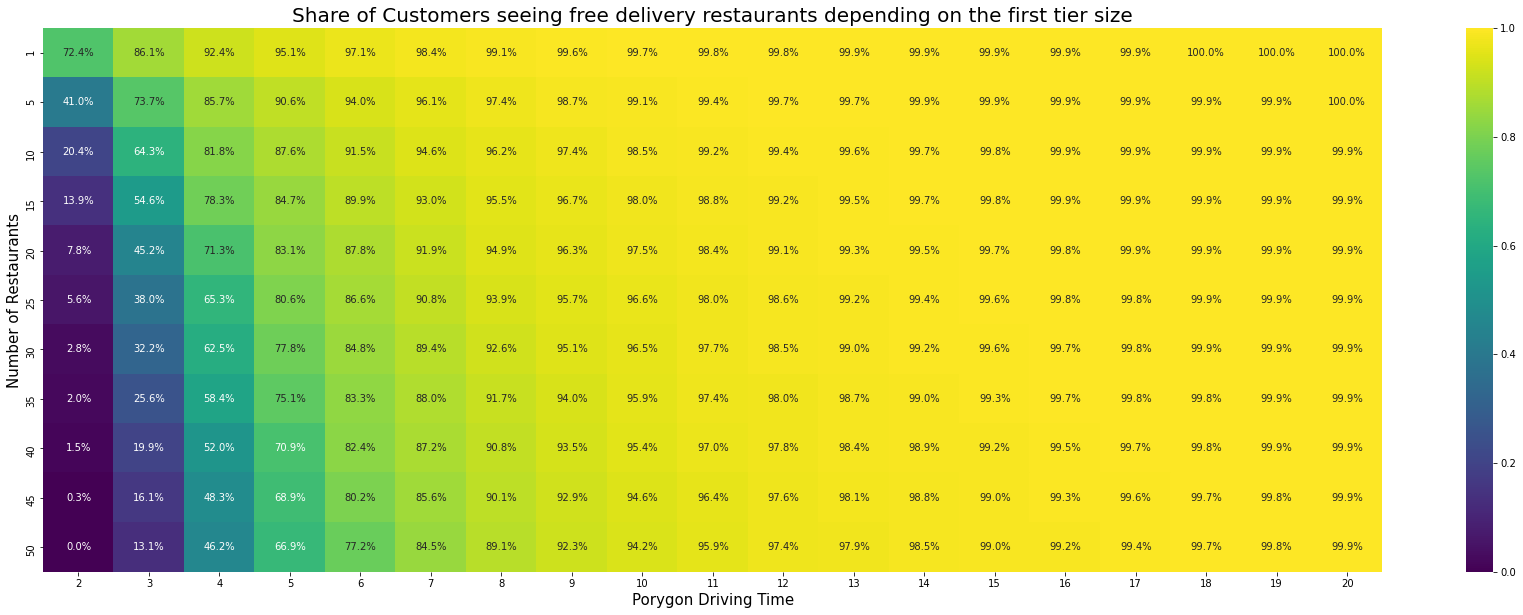

In [111]:
plt.subplots(figsize=(30,10))
sns.heatmap(df2, fmt=".1%", annot=True, cmap='viridis')
plt.title('Share of Customers seeing free delivery restaurants depending on the first tier size', fontsize = 20)

plt.xlabel('Porygon Driving Time', fontsize = 15)
plt.ylabel('Number of Restaurants', fontsize = 15)